# Price Forecast Model

This notebook contains the exploratory data analysis, model training, and evaluation steps for the price forecasting model.

In [147]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style='whitegrid')

In [148]:
# Load the dataset
df = pd.read_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\data\SAFEX_wheat_monday_df.csv')

# Display the first few rows of the dataset
df.tail()

,Date,Price,volume,open_price,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,Price_diff,year_month,max_temp,precipitation,avg_temp,min_temp,active_flag,day
451,2023-11-13,5926.0,1211.0,5901.0,18.7266,579.00,602.25,3794.0,3644.0,-16.0,202311.0,81.25250,1.401666,68.88585,56.51500,0,Monday
452,2023-11-20,5874.0,2815.0,5868.0,18.3407,543.50,570.50,4180.0,3910.0,-26.0,202311.0,81.25250,1.401666,68.88585,56.51500,0,Monday
453,2023-11-27,5814.0,3134.0,5870.0,18.6543,534.25,561.00,4426.0,4055.0,-52.0,202311.0,81.25250,1.401666,68.88585,56.51500,0,Monday
454,2023-12-04,5819.0,611.0,5753.0,18.8012,595.75,620.50,4340.0,4031.0,21.0,202312.0,80.38685,3.568334,69.71180,59.02715,0,Monday
455,2023-12-11,5876.0,1852.0,5870.0,19.0853,591.25,609.50,4450.0,4143.0,5.0,202312.0,80.38685,3.568334,69.71180,59.02715,0,Monday


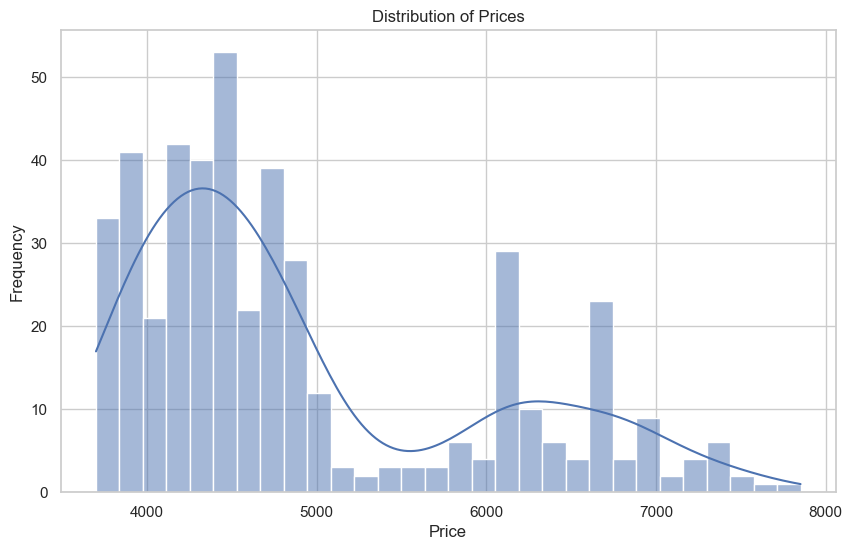

In [149]:
# Exploratory Data Analysis
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [150]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create covid_flag for data in 2020
df['covid_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2020 else 0)

# Create war_flag for data in 2022
df['war_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2022 else 0)

# Display the updated dataframe
df[['Date', 'covid_flag', 'war_flag']].head()
# Add a seasonality column based on the month
df['seasonality'] = df['Date'].dt.month % 12 // 3 + 1


# Display the updated dataframe with the new column
df[['Date', 'seasonality']].head()



,Date,seasonality
0,2015-03-23,2
1,2015-03-30,2
2,2015-04-06,2
3,2015-04-13,2
4,2015-04-20,2


In [151]:
# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

# Calculate EMA
def calculate_ema(data, column, span):
    data[f'EMA_{span}'] = data[column].ewm(span=span, adjust=False).mean()

# Calculate MACD
def calculate_macd(data, column, short_span=12, long_span=26, signal_span=9):
    data['MACD'] = data[column].ewm(span=short_span, adjust=False).mean() - data[column].ewm(span=long_span, adjust=False).mean()
    data['MACD_Signal'] = data['MACD'].ewm(span=signal_span, adjust=False).mean()

# Apply calculations
calculate_rsi(df)
calculate_ema(df, 'Price', span=20)  # Example: 20-day EMA
calculate_macd(df, 'Price')

# Display the updated DataFrame
print(df[['Date', 'Price', 'RSI', 'EMA_20', 'MACD', 'MACD_Signal']].head())

        Date   Price  RSI       EMA_20      MACD  MACD_Signal
0 2015-03-23  3795.0  NaN  3795.000000  0.000000     0.000000
1 2015-03-30  3800.0  NaN  3795.476190  0.398860     0.079772
2 2015-04-06  3800.0  NaN  3795.907029  0.706812     0.205180
3 2015-04-13  3800.0  NaN  3796.296836  0.940031     0.352150
4 2015-04-20  3700.0  NaN  3787.125709 -6.865169    -1.091314


In [152]:
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

# Initialize the starting point for the loop
current_date = pd.Timestamp('2023-05-01')
horizon = 33  # Number of weeks to extrapolate

# Loop until the end of December 2023
while current_date <= pd.Timestamp('2023-12-31'):
    data_2022_2023 = df[df['Date'] < current_date]
    for i in range (0, horizon):
        # Use 20-day moving averages for extrapolation
        forecasted_values = {}
        for column in ['Price_diff', 'volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                   'WZ1 Comdty', 'YW1 Comdty', 'max_temp', 'precipitation', 'avg_temp', 'min_temp', 'RSI', 'EMA_20', 'MACD', 'MACD_Signal']:
            if len(data_2022_2023[column]) >= 20:
                forecasted_values[column] = data_2022_2023[column].rolling(window=156).mean().iloc[-1]
            else:
                forecasted_values[column] = data_2022_2023[column].mean()

        # Create a new row with extrapolated data
        new_row = {
            'Date': current_date + timedelta(weeks=i),
            'volume': forecasted_values['volume'],
            'open_price': forecasted_values['open_price'],
            'USDZAR Curncy': forecasted_values['USDZAR Curncy'],
            'W 1 Comdty': forecasted_values['W 1 Comdty'],
            'W 2 Comdty': forecasted_values['W 2 Comdty'],
            'WZ1 Comdty': forecasted_values['WZ1 Comdty'],
            'YW1 Comdty': forecasted_values['YW1 Comdty'],
            'Price_diff': forecasted_values['Price_diff'],
            'RSI': forecasted_values['RSI'],
            'EMA_20': forecasted_values['EMA_20'],
            'MACD': forecasted_values['MACD'],
            'MACD_Signal': forecasted_values['MACD_Signal'],
            'year_month': (current_date + timedelta(weeks=i)).year * 100 + (current_date + timedelta(weeks=i)).month,
            'max_temp': forecasted_values['max_temp'],
            'precipitation': forecasted_values['precipitation'],
            'avg_temp': forecasted_values['avg_temp'],
            'min_temp': forecasted_values['min_temp'],
            'active_flag': 0,
            'covid_flag': 0,
            'war_flag': 0,
            'day': 'Friday',
            'seasonality': (current_date + timedelta(weeks=i)).month % 12 // 3 + 1
        }
        # Append the new row to the dataframe
        data_2022_2023 = pd.concat([data_2022_2023, pd.DataFrame([new_row])], ignore_index=True)
    print(f"Extrapolated data until {current_date + timedelta(weeks=horizon)}")
    print(data_2022_2023.tail(32))
    # Prepare the data for training
    features = ['volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                'WZ1 Comdty', 'YW1 Comdty', 'Price_diff', 'max_temp', 'precipitation', 
                'avg_temp', 'min_temp']
    target = 'Price'
    X_train = df[df['Date'] <= current_date][features].astype(float)
    y_train = df[df['Date'] <= current_date][target].astype(float)
    X_test = data_2022_2023[data_2022_2023['Date'] > current_date][features].astype(float)
    y_test = df[df['Date'] > current_date][target].astype(float)
    # Train the XGB model
    xgb_model = XGBRegressor(random_state=42, max_depth=9, n_estimators=200, learning_rate=0.15)
    # Drop NaN values from training data
    print(X_train.isnull().sum())
    print(y_train.isnull().sum())
    # Train the XGB model
    xgb_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    print(len(y_pred))
    print(len(y_test))  
    
    horizon_array = np.arange(1, horizon + 1)
    # Ensure the lengths of y_pred and horizon_array match
    if len(y_pred) != len(horizon_array):
        horizon_array = horizon_array[:len(y_pred)]

    # Create a DataFrame for predictions
    prediction_current_date = pd.DataFrame({
        'Date': X_test.index,
        'Predicted_Price': y_pred,
        'Horizon': horizon_array
    })
    prediction_current_date = pd.DataFrame({'Date': X_test.index, 'Predicted_Price': y_pred, 'Horizon':horizon_array })
    current_date_str = current_date.strftime('%Y-%m-%d')
    prediction_current_date.to_csv(f'predictions_{current_date_str}.csv', index=False)
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
    current_date += timedelta(weeks=1)
    horizon -= 1
    

Extrapolated data until 2023-12-18 00:00:00
          Date  Price      volume   open_price  USDZAR Curncy  W 1 Comdty  \
424 2023-05-08    NaN  867.721893  5816.970061      16.109939  699.731499   
425 2023-05-15    NaN  871.893188  5823.040382      16.095109  700.853175   
426 2023-05-22    NaN  876.802759  5828.899615      16.080616  702.159926   
427 2023-05-29    NaN  881.359187  5835.366920      16.070597  703.180182   
428 2023-06-05    NaN  886.823028  5841.747477      16.062279  704.384863   
429 2023-06-12    NaN  890.565484  5848.585602      16.058318  705.621304   
430 2023-06-19    NaN  893.479365  5855.243202      16.051628  706.908941   
431 2023-06-26    NaN  897.309361  5861.565274      16.043472  708.331434   
432 2023-07-03    NaN  900.561344  5868.177872      16.035585  709.759840   
433 2023-07-10    NaN  904.853404  5875.108499      16.029493  711.171762   
434 2023-07-17    NaN  908.429387  5881.974579      16.024195  712.366774   
435 2023-07-24    NaN  909.51547

ValueError: Per-column arrays must each be 1-dimensional

In [153]:
import os
# Define the directory where the prediction CSV files are stored
predictions_dir = r'./'  # Replace with the actual directory path if different

# List all CSV files in the directory
csv_files = [file for file in os.listdir(predictions_dir) if file.startswith('predictions_') and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
predictions_list = []

# Extract the date from the file name and add it as a new column
for file in csv_files:
    file_date = file.split('_')[1].split('.')[0]  # Extract the date part from the file name
    df_new = pd.read_csv(os.path.join(predictions_dir, file))
    df_new['File_Date'] = file_date  # Add the extracted date as a new column
    predictions_list.append(df_new)

# Concatenate all DataFrames into a single DataFrame
all_predictions = pd.concat(predictions_list, ignore_index=True)

# Display the combined DataFrame
print(all_predictions.head())
print(f"Total predictions loaded: {len(all_predictions)}")


   Date  Predicted_Price  Horizon   File_Date
0   424        5738.3100        1  2023-05-01
1   425        5738.3100        2  2023-05-01
2   426        5738.3100        3  2023-05-01
3   427        5738.3125        4  2023-05-01
4   428        5738.3125        5  2023-05-01
Total predictions loaded: 1056


In [154]:
# Convert 'File_Date' to datetime format
all_predictions['File_Date'] = pd.to_datetime(all_predictions['File_Date'])

# Calculate the prediction date by adding the horizon in weeks
all_predictions['prediction_date'] = all_predictions['File_Date'] + pd.to_timedelta(all_predictions['Horizon'], unit='W')

# Display the updated DataFrame
print(all_predictions.head())

   Date  Predicted_Price  Horizon  File_Date prediction_date
0   424        5738.3100        1 2023-05-01      2023-05-08
1   425        5738.3100        2 2023-05-01      2023-05-15
2   426        5738.3100        3 2023-05-01      2023-05-22
3   427        5738.3125        4 2023-05-01      2023-05-29
4   428        5738.3125        5 2023-05-01      2023-06-05


In [155]:
all_predictions.drop(columns=['Date'], inplace=True)
all_predictions.rename(columns={'prediction_date': 'Date'}, inplace=True)

In [156]:
# Ensure the 'Date' column in both DataFrames is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'], errors='coerce')

# Convert the 'Date' columns to string format for matching
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
all_predictions['Date'] = all_predictions['Date'].dt.strftime('%Y-%m-%d')

# Merge the DataFrames on the 'Date' column
merged_predictions = all_predictions.merge(df[['Date', 'Price']], on='Date', how='left')

# Display the merged DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price
0        5738.3100        1 2023-05-01  2023-05-08  6494.0
1        5738.3100        2 2023-05-01  2023-05-15  6541.0
2        5738.3100        3 2023-05-01  2023-05-22  6338.0
3        5738.3125        4 2023-05-01  2023-05-29  6424.0
4        5738.3125        5 2023-05-01  2023-06-05  6326.0


In [157]:
# Map the 'File_Date' to the corresponding 'Price' from the 'df' DataFrame
merged_predictions['Trained_Price'] = merged_predictions['File_Date'].dt.strftime('%Y-%m-%d').map(
    df.set_index('Date')['Price']
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price
0        5738.3100        1 2023-05-01  2023-05-08  6494.0         6731.0
1        5738.3100        2 2023-05-01  2023-05-15  6541.0         6731.0
2        5738.3100        3 2023-05-01  2023-05-22  6338.0         6731.0
3        5738.3125        4 2023-05-01  2023-05-29  6424.0         6731.0
4        5738.3125        5 2023-05-01  2023-06-05  6326.0         6731.0


In [158]:
# Calculate MAPE
merged_predictions['mape'] = abs(merged_predictions['Predicted_Price'] - merged_predictions['Price']) / merged_predictions['Price']

# Calculate Directional Accuracy
merged_predictions['dir_acc'] = merged_predictions.apply(
    lambda row: 1 if (
        (row['Price'] > row['Trained_Price'] and row['Predicted_Price'] > row['Trained_Price']) or
        (row['Price'] < row['Trained_Price'] and row['Predicted_Price'] < row['Trained_Price']) or
        (row['Price'] == row['Trained_Price'])
    ) else 0, axis=1
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price  \
0        5738.3100        1 2023-05-01  2023-05-08  6494.0         6731.0   
1        5738.3100        2 2023-05-01  2023-05-15  6541.0         6731.0   
2        5738.3100        3 2023-05-01  2023-05-22  6338.0         6731.0   
3        5738.3125        4 2023-05-01  2023-05-29  6424.0         6731.0   
4        5738.3125        5 2023-05-01  2023-06-05  6326.0         6731.0   

       mape  dir_acc  
0  0.116367        1  
1  0.122717        1  
2  0.094618        1  
3  0.106738        1  
4  0.092900        1  


In [159]:
merged_predictions=merged_predictions.dropna(axis=0, how='any')

In [162]:
# Group by 'Horizon' and calculate the sum and count of 'dir_acc' values
horizon_dir_acc_stats = merged_predictions.groupby('Horizon')['dir_acc'].agg(['sum', 'count'])

# Calculate the percentage
horizon_dir_acc_stats['percentage'] = (horizon_dir_acc_stats['sum'] / horizon_dir_acc_stats['count']) * 100

# Average MAPE
horizon_dir_acc_stats['avg_mape'] = merged_predictions.groupby('Horizon')['mape'].mean()

# Display the result
print(horizon_dir_acc_stats)

         sum  count  percentage  avg_mape
Horizon                                  
1         17     32   53.125000  0.058834
2         19     31   61.290323  0.057071
3         19     30   63.333333  0.054926
4         19     29   65.517241  0.053790
5         20     28   71.428571  0.053202
6         19     27   70.370370  0.051999
7         17     26   65.384615  0.049202
8         20     25   80.000000  0.049414
9         18     24   75.000000  0.047197
10        18     23   78.260870  0.047420
11        18     22   81.818182  0.047214
12        17     21   80.952381  0.047347
13        17     20   85.000000  0.044919
14        16     19   84.210526  0.044116
15        18     18  100.000000  0.042380
16        17     17  100.000000  0.037399
17        16     16  100.000000  0.034000
18        15     15  100.000000  0.031625
19        14     14  100.000000  0.030634
20        13     13  100.000000  0.026933
21        12     12  100.000000  0.023027
22        11     11  100.000000  0

In [161]:
sum_dir_acc = merged_predictions['dir_acc'].sum()
print(sum_dir_acc)

425


In [163]:
merged_predictions.to_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\data\merged_prediction_monday.csv', index=False)